In [1]:
!python -m pip install --user --upgrade pip
!pip install --user keras
!pip install --user tensorflow
!pip install --user -U numpy

distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


  Stored in directory: C:\Users\mayingzh\AppData\Local\pip\Cache\wheels\7c\06\54\bc84598ba1daf8f970247f550b175aaaee85f68b4b0c5ab2c6
  Stored in directory: C:\Users\mayingzh\AppData\Local\pip\Cache\wheels\5c\2e\7e\a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
  Stored in directory: C:\Users\mayingzh\AppData\Local\pip\Cache\wheels\ee\98\38\46cbcc5a93cfea5492d19c38562691ddb23b940176c14f7b48
Successfully built termcolor gast absl-py


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [13]:
# Use CPU only
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [14]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn import preprocessing
import matplotlib.pyplot as plt

## Load data and do data normalization

In [2]:
df = pd.read_csv('Options.csv')
df.head()

,ticker,date,exdate,maturity,strike_price,best_offer,impl_volatility,underlying_price,cp_flag_C,cp_flag_P
0,AXP,2013-01-02,2013-01-04,2,60.0,0.03,0.181376,58.75,1,0
1,AXP,2013-01-02,2013-01-04,2,62.5,0.05,0.450289,58.75,1,0
2,AXP,2013-01-02,2013-01-04,2,65.0,0.05,0.676564,58.75,1,0
3,AXP,2013-01-02,2013-01-04,2,67.5,0.50,1.369425,58.75,1,0
4,AXP,2013-01-02,2013-01-04,2,70.0,0.01,0.888123,58.75,1,0


In [5]:
y = df['best_offer'].values
X = df[['maturity', 'strike_price', 'impl_volatility', 'underlying_price', 'cp_flag_C', 'cp_flag_P']]

In [7]:
# Normalize the data to build a regression neural network model
sc= preprocessing.MinMaxScaler()
X= sc.fit_transform(X)
y= y.reshape(-1,1)
y=sc.fit_transform(y)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
print(X_train.shape)
print(y_train.shape)

(1573351, 6)
(1573351, 1)


In [10]:
XX_train, XX_validation, yy_train, yy_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## Build a keras Sequential model

In [11]:
# Built Keras sequential model with 3 hidden layer, and after the first hidden layer.
model = Sequential([
    Dense(64, activation='relu', input_shape=(6,)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='linear'),
])

In [25]:
# Enable early stopping based on the loss of validation data
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=20)

In [15]:
# Because it is a simple regression problem, we should custom metrics function
from keras import backend as K
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis = -1))

def r_square(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

In [16]:
# use mean_squared_error to compile regression model loss
model.compile(
  optimizer='adam',
  loss='mse',
  metrics=[rmse, r_square],
)

In [17]:
# fit the model
result = model.fit(XX_train, 
                   yy_train,
                   epochs = 200,
                   batch_size=256,
                   validation_data=(XX_validation, yy_validation),
                   callbacks = [es]
                  )

Train on 1258680 samples, validate on 314671 samples
Epoch 1/200
1258680/1258680 [==============================] - 17s 13us/step - loss: 1.2521e-04 - rmse: 0.0041 - r_square: 0.9881 - val_loss: 2.6333e-05 - val_rmse: 0.0039 - val_r_square: 0.9974
Epoch 2/200
1258680/1258680 [==============================] - 16s 12us/step - loss: 1.3736e-05 - rmse: 0.0025 - r_square: 0.9986 - val_loss: 9.3649e-06 - val_rmse: 0.0021 - val_r_square: 0.9991
Epoch 3/200
1258680/1258680 [==============================] - 20s 16us/step - loss: 1.0946e-05 - rmse: 0.0022 - r_square: 0.9989 - val_loss: 1.0919e-05 - val_rmse: 0.0022 - val_r_square: 0.9989
Epoch 4/200
1258680/1258680 [==============================] - 17s 14us/step - loss: 9.1033e-06 - rmse: 0.0019 - r_square: 0.9991 - val_loss: 5.6784e-06 - val_rmse: 0.0014 - val_r_square: 0.9994
Epoch 5/200
1258680/1258680 [==============================] - 17s 13us/step - loss: 8.0413e-06 - rmse: 0.0018 - r_square: 0.9992 - val_loss: 5.9252e-06 - val_rmse: 0.

1258680/1258680 [==============================] - 15s 12us/step - loss: 4.7911e-06 - rmse: 0.0013 - r_square: 0.9995 - val_loss: 4.1476e-06 - val_rmse: 0.0012 - val_r_square: 0.9996
Epoch 43/200
1258680/1258680 [==============================] - 16s 13us/step - loss: 4.7948e-06 - rmse: 0.0013 - r_square: 0.9995 - val_loss: 4.2708e-06 - val_rmse: 0.0013 - val_r_square: 0.9996
Epoch 44/200
1258680/1258680 [==============================] - 15s 12us/step - loss: 4.7686e-06 - rmse: 0.0013 - r_square: 0.9995 - val_loss: 4.3124e-06 - val_rmse: 0.0012 - val_r_square: 0.9996
Epoch 45/200
1258680/1258680 [==============================] - 15s 12us/step - loss: 4.7502e-06 - rmse: 0.0013 - r_square: 0.9995 - val_loss: 4.0832e-06 - val_rmse: 0.0011 - val_r_square: 0.9996
Epoch 46/200
1258680/1258680 [==============================] - 15s 12us/step - loss: 4.7131e-06 - rmse: 0.0013 - r_square: 0.9995 - val_loss: 4.1871e-06 - val_rmse: 0.0011 - val_r_square: 0.9996
Epoch 47/200
1258680/1258680 [===

Epoch 84/200
1258680/1258680 [==============================] - 16s 13us/step - loss: 4.4316e-06 - rmse: 0.0012 - r_square: 0.9996 - val_loss: 4.8910e-06 - val_rmse: 0.0014 - val_r_square: 0.9995
Epoch 85/200
1258680/1258680 [==============================] - 23s 18us/step - loss: 4.3917e-06 - rmse: 0.0012 - r_square: 0.9996 - val_loss: 4.4650e-06 - val_rmse: 0.0011 - val_r_square: 0.9996
Epoch 86/200
1258680/1258680 [==============================] - 20s 16us/step - loss: 4.3903e-06 - rmse: 0.0012 - r_square: 0.9996 - val_loss: 3.8902e-06 - val_rmse: 0.0011 - val_r_square: 0.9996
Epoch 87/200
1258680/1258680 [==============================] - 20s 16us/step - loss: 4.3671e-06 - rmse: 0.0012 - r_square: 0.9996 - val_loss: 4.2352e-06 - val_rmse: 0.0011 - val_r_square: 0.9996
Epoch 88/200
1258680/1258680 [==============================] - 18s 14us/step - loss: 4.3983e-06 - rmse: 0.0012 - r_square: 0.9996 - val_loss: 4.4021e-06 - val_rmse: 0.0011 - val_r_square: 0.9996
Epoch 89/200
1258680

Epoch 126/200
1258680/1258680 [==============================] - 16s 12us/step - loss: 4.2292e-06 - rmse: 0.0012 - r_square: 0.9996 - val_loss: 4.9778e-06 - val_rmse: 0.0013 - val_r_square: 0.9995
Epoch 127/200
1258680/1258680 [==============================] - 16s 13us/step - loss: 4.2265e-06 - rmse: 0.0012 - r_square: 0.9996 - val_loss: 5.1165e-06 - val_rmse: 0.0013 - val_r_square: 0.9995
Epoch 128/200
1258680/1258680 [==============================] - 16s 12us/step - loss: 4.2066e-06 - rmse: 0.0012 - r_square: 0.9996 - val_loss: 3.8690e-06 - val_rmse: 0.0010 - val_r_square: 0.9996
Epoch 129/200
1258680/1258680 [==============================] - 16s 12us/step - loss: 4.2653e-06 - rmse: 0.0012 - r_square: 0.9996 - val_loss: 4.0233e-06 - val_rmse: 0.0011 - val_r_square: 0.9996
Epoch 130/200
1258680/1258680 [==============================] - 16s 12us/step - loss: 4.2215e-06 - rmse: 0.0012 - r_square: 0.9996 - val_loss: 4.3293e-06 - val_rmse: 0.0011 - val_r_square: 0.9996
Epoch 131/200
1

1258680/1258680 [==============================] - 15s 12us/step - loss: 4.1682e-06 - rmse: 0.0012 - r_square: 0.9996 - val_loss: 4.1121e-06 - val_rmse: 0.0012 - val_r_square: 0.9996
Epoch 168/200
1258680/1258680 [==============================] - 15s 12us/step - loss: 4.1163e-06 - rmse: 0.0011 - r_square: 0.9996 - val_loss: 4.3409e-06 - val_rmse: 0.0012 - val_r_square: 0.9996
Epoch 169/200
1258680/1258680 [==============================] - 15s 12us/step - loss: 4.1531e-06 - rmse: 0.0012 - r_square: 0.9996 - val_loss: 3.8064e-06 - val_rmse: 0.0011 - val_r_square: 0.9996
Epoch 170/200
1258680/1258680 [==============================] - 15s 12us/step - loss: 4.1190e-06 - rmse: 0.0011 - r_square: 0.9996 - val_loss: 4.0852e-06 - val_rmse: 0.0011 - val_r_square: 0.9996
Epoch 171/200
1258680/1258680 [==============================] - 15s 12us/step - loss: 4.1115e-06 - rmse: 0.0011 - r_square: 0.9996 - val_loss: 4.2169e-06 - val_rmse: 0.0012 - val_r_square: 0.9996
Epoch 172/200
1258680/1258680

In [24]:
model.save_weights('model.h5')

In [18]:
predictions = model.predict(X_test)
print(predictions[:10])

[[0.05586029]
 [0.00241558]
 [0.00177731]
 [0.07973139]
 [0.03048718]
 [0.00082504]
 [0.00016485]
 [0.11386313]
 [0.00207109]
 [0.00079346]]


In [19]:
y_test[:10]

array([[0.05267722],
       [0.00354072],
       [0.00187875],
       [0.07471638],
       [0.03136065],
       [0.0003613 ],
       [0.00028904],
       [0.11337524],
       [0.00122841],
       [0.00050582]])

## Plot learning curves including R^2 and RMSE

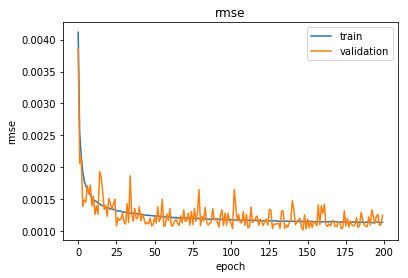

In [21]:
# plot training curve for rmse
plt.plot(result.history['rmse'])
plt.plot(result.history['val_rmse'])
plt.title('rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

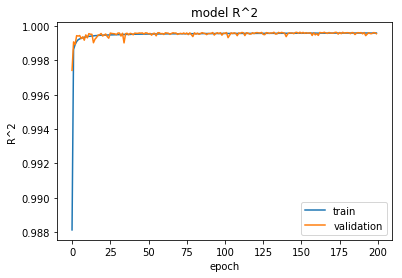

In [22]:
# plot training curve for R^2
plt.plot(result.history['r_square'])
plt.plot(result.history['val_r_square'])
plt.title('model R^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

In [24]:
import sklearn.metrics as skm, math
print("\n")
print("Mean absolute error (MAE):      %f" % skm.mean_absolute_error(y_test,predictions))
print("Mean squared error (MSE):       %f" % skm.mean_squared_error(y_test,predictions))
print("Root mean squared error (RMSE): %f" % math.sqrt(skm.mean_squared_error(y_test,predictions)))
print("R square (R^2):                 %f" % skm.r2_score(y_test,predictions))



Mean absolute error (MAE):      0.001252
Mean squared error (MSE):       0.000004
Root mean squared error (RMSE): 0.002118
R square (R^2):                 0.999578


## Try dropout

In [27]:
model2 = Sequential([
    Dense(64, activation='relu', input_shape=(6,)),
    Dropout(0.1),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='linear'),
])
model2.compile(
  optimizer='adam',
  loss='mse',
  metrics=[rmse, r_square],
)
# fit the model
result2 = model2.fit(XX_train, 
                   yy_train,
                   epochs = 150,
                   batch_size=256,
                   validation_data=(XX_validation, yy_validation),
                   callbacks = [es]
                  )

Train on 1258680 samples, validate on 314671 samples
Epoch 1/150
1258680/1258680 [==============================] - 20s 16us/step - loss: 2.8917e-04 - rmse: 0.0080 - r_square: 0.9724 - val_loss: 2.5321e-04 - val_rmse: 0.0088 - val_r_square: 0.9761
Epoch 2/150
1258680/1258680 [==============================] - 19s 15us/step - loss: 2.8919e-05 - rmse: 0.0033 - r_square: 0.9972 - val_loss: 2.1958e-04 - val_rmse: 0.0078 - val_r_square: 0.9793
Epoch 3/150
1258680/1258680 [==============================] - 19s 15us/step - loss: 1.8725e-05 - rmse: 0.0027 - r_square: 0.9982 - val_loss: 1.9962e-04 - val_rmse: 0.0072 - val_r_square: 0.9813
Epoch 4/150
1258680/1258680 [==============================] - 19s 15us/step - loss: 1.4866e-05 - rmse: 0.0024 - r_square: 0.9985 - val_loss: 2.3551e-04 - val_rmse: 0.0084 - val_r_square: 0.9778
Epoch 5/150
1258680/1258680 [==============================] - 19s 15us/step - loss: 1.3045e-05 - rmse: 0.0022 - r_square: 0.9987 - val_loss: 1.6788e-04 - val_rmse: 0.

1258680/1258680 [==============================] - 20s 16us/step - loss: 6.4506e-06 - rmse: 0.0015 - r_square: 0.9994 - val_loss: 1.4504e-04 - val_rmse: 0.0058 - val_r_square: 0.9865
Epoch 43/150
1258680/1258680 [==============================] - 20s 16us/step - loss: 6.2947e-06 - rmse: 0.0015 - r_square: 0.9994 - val_loss: 1.6168e-04 - val_rmse: 0.0061 - val_r_square: 0.9849
Epoch 44/150
1258680/1258680 [==============================] - 19s 15us/step - loss: 6.2979e-06 - rmse: 0.0015 - r_square: 0.9994 - val_loss: 1.5177e-04 - val_rmse: 0.0059 - val_r_square: 0.9859
Epoch 45/150
1258680/1258680 [==============================] - 19s 15us/step - loss: 6.2846e-06 - rmse: 0.0015 - r_square: 0.9994 - val_loss: 1.5278e-04 - val_rmse: 0.0062 - val_r_square: 0.9858
Epoch 46/150
1258680/1258680 [==============================] - 21s 16us/step - loss: 6.2389e-06 - rmse: 0.0015 - r_square: 0.9994 - val_loss: 1.5832e-04 - val_rmse: 0.0062 - val_r_square: 0.9852
Epoch 47/150
1258680/1258680 [===

In [29]:
predictions2 = model2.predict(X_test)
print(predictions2[:10])
print("\n")
print("Mean absolute error (MAE):      %f" % skm.mean_absolute_error(y_test,predictions2))
print("Mean squared error (MSE):       %f" % skm.mean_squared_error(y_test,predictions2))
print("Root mean squared error (RMSE): %f" % math.sqrt(skm.mean_squared_error(y_test,predictions2)))
print("R square (R^2):                 %f" % skm.r2_score(y_test,predictions2))

[[0.04803328]
 [0.00311903]
 [0.00254652]
 [0.06959646]
 [0.02624514]
 [0.00024288]
 [0.00085834]
 [0.10023231]
 [0.00202981]
 [0.00094579]]


Mean absolute error (MAE):      0.005810
Mean squared error (MSE):       0.000146
Root mean squared error (RMSE): 0.012069
R square (R^2):                 0.986288


## Try batch normalization technique to regularize neurons

In [40]:
from keras.layers.normalization import BatchNormalization
model3 = Sequential([
    BatchNormalization(),
    Dense(64, activation='relu', input_shape=(6,)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='linear'),
])
model3.compile(
  optimizer='adam',
  loss='mse',
  metrics=[rmse, r_square],
)
# fit the model
result3 = model3.fit(X_train, 
                   y_train,
                   epochs = 200,
                   batch_size=256,
                   validation_data=(X_test, y_test),
                   callbacks = [es]
                  )

Train on 487123 samples, validate on 239927 samples
Epoch 1/200
487123/487123 [==============================] - 4s 8us/step - loss: 0.0010 - rmse: 0.0176 - r_square: 0.9569 - val_loss: 1.4472e-04 - val_rmse: 0.0078 - val_r_square: 0.9940
Epoch 2/200
487123/487123 [==============================] - 3s 7us/step - loss: 3.5415e-04 - rmse: 0.0125 - r_square: 0.9854 - val_loss: 6.6277e-05 - val_rmse: 0.0060 - val_r_square: 0.9973
Epoch 3/200
487123/487123 [==============================] - 3s 7us/step - loss: 3.1503e-04 - rmse: 0.0114 - r_square: 0.9871 - val_loss: 1.5766e-04 - val_rmse: 0.0077 - val_r_square: 0.9935
Epoch 4/200
487123/487123 [==============================] - 3s 7us/step - loss: 3.0017e-04 - rmse: 0.0109 - r_square: 0.9877 - val_loss: 1.3407e-04 - val_rmse: 0.0090 - val_r_square: 0.9944
Epoch 5/200
487123/487123 [==============================] - 3s 7us/step - loss: 2.9197e-04 - rmse: 0.0109 - r_square: 0.9880 - val_loss: 1.4660e-04 - val_rmse: 0.0089 - val_r_square: 0.99

Epoch 86/200
487123/487123 [==============================] - 3s 7us/step - loss: 2.1264e-04 - rmse: 0.0090 - r_square: 0.9912 - val_loss: 2.0521e-05 - val_rmse: 0.0029 - val_r_square: 0.9992
Epoch 87/200
487123/487123 [==============================] - 3s 7us/step - loss: 2.2124e-04 - rmse: 0.0091 - r_square: 0.9909 - val_loss: 1.7220e-05 - val_rmse: 0.0027 - val_r_square: 0.9993
Epoch 88/200
487123/487123 [==============================] - 3s 7us/step - loss: 2.0725e-04 - rmse: 0.0088 - r_square: 0.9915 - val_loss: 3.5184e-05 - val_rmse: 0.0041 - val_r_square: 0.9986
Epoch 89/200
487123/487123 [==============================] - 3s 7us/step - loss: 2.1255e-04 - rmse: 0.0090 - r_square: 0.9913 - val_loss: 2.6888e-05 - val_rmse: 0.0031 - val_r_square: 0.9989
Epoch 90/200
487123/487123 [==============================] - 3s 7us/step - loss: 2.0636e-04 - rmse: 0.0088 - r_square: 0.9915 - val_loss: 1.9418e-05 - val_rmse: 0.0028 - val_r_square: 0.9992
Epoch 91/200
487123/487123 [============

In [43]:
predictions3 = model3.predict(X_test)
print(predictions3[:10])
print("\n")
print("Mean absolute error (MAE):      %f" % skm.mean_absolute_error(y_test,predictions3))
print("Mean squared error (MSE):       %f" % skm.mean_squared_error(y_test,predictions3))
print("Root mean squared error (RMSE): %f" % math.sqrt(sklearn.metrics.mean_squared_error(y_test,predictions3)))
print("R square (R^2):                 %f" % skm.r2_score(y_test,predictions3))

[[ 0.04051611]
 [ 0.34659985]
 [ 0.12310097]
 [ 0.05491048]
 [ 0.02672598]
 [ 0.01006674]
 [ 0.5663377 ]
 [-0.00239683]
 [-0.00114246]
 [ 0.18679872]]


Mean absolute error (MAE):      0.003646
Mean squared error (MSE):       0.000030
Root mean squared error (RMSE): 0.005486
R square (R^2):                 0.998779


## Reference: 
&emsp;&emsp;What does 'Accuracy' mean in Regression? https://github.com/keras-team/keras/issues/7947 <br>
&emsp;&emsp;https://keras.io/metrics/<br>
&emsp;&emsp;Scale, Standardize, or Normalize with Scikit-Learn https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02 <br>
&emsp;&emsp;The Day my Computer Won the Nobel Prize (Neural Network Option Pricing)  https://medium.com/datadriveninvestor/the-day-my-computer-won-the-nobel-prize-neural-network-option-pricing-d29b4379f1d2 <br>